## Log-playback (expert) trajectory extraction and usage

This notebook demonstrates how to extract expert actions using different dynamics models and step through scene with those actions. 

In [25]:
import os
import torch
from pathlib import Path
import mediapy
import matplotlib.pyplot as plt

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig
from pygpudrive.env.env_torch import GPUDriveTorchEnv

### Configurations

In [32]:
DYNAMICS_MODEL = "state" # "delta_local" or "state"
DATA_PATH = "data/formatted_json_v2_no_tl_train"
MAX_NUM_OBJECTS = 128
NUM_ENVS = 4

# Configs
render_config = RenderConfig(draw_obj_idx=True)
scene_config = SceneConfig(path=DATA_PATH, num_scenes=NUM_ENVS)
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

### Make environment

In [3]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    max_cont_agents=MAX_NUM_OBJECTS,
    device="cpu",
    render_config=render_config,
    action_type="continuous" # "continuous" or "discrete"
)


--- Ratio unique scenes / number of worls = 4 / 4 ---



### Get log-playback (expert) actions

- Different dynamics models have different action spaces. For details, [see the docs.](https://github.com/Emerge-Lab/gpudrive/tree/main/pygpudrive/env)

In [45]:
full_expert_actions = torch.zeros((NUM_ENVS, MAX_NUM_OBJECTS, env_config.episode_len, 7))

# Extract full expert trajectory
expert_actions, _, _ = env.get_expert_actions()

if DYNAMICS_MODEL == "state":
    
    full_expert_actions[:, :, :, :2] = expert_actions[:, :, :, :2] # Pos x, y
    full_expert_actions[:, :, :, 2] = torch.ones((NUM_ENVS, MAX_NUM_OBJECTS, env_config.episode_len)) # Pos z
    full_expert_actions[:, :, :, 3] = expert_actions[:, :, :, 2] # Yaw
    full_expert_actions[:, :, :, 4:6] = expert_actions[:, :, :, 2:4] # Vel x, y
    #full_expert_actions[:, :, :, 6] is Vel z
    

In [46]:
expert_actions.max(), expert_actions.min()

(tensor(7.3964e+31), tensor(-2.2531e+29))

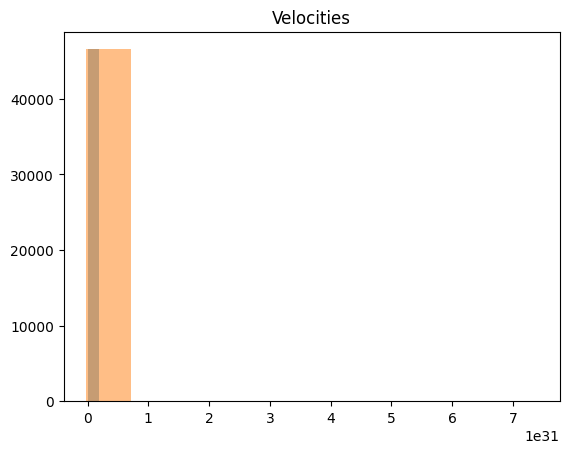

In [41]:
plt.title('Velocities')
plt.hist(expert_actions[:, :, :, 3].flatten().numpy(), label='x', alpha=0.5, bins=10);
plt.hist(expert_actions[:, :, :, 4].flatten().numpy(), label='y', alpha=0.5, bins=10);

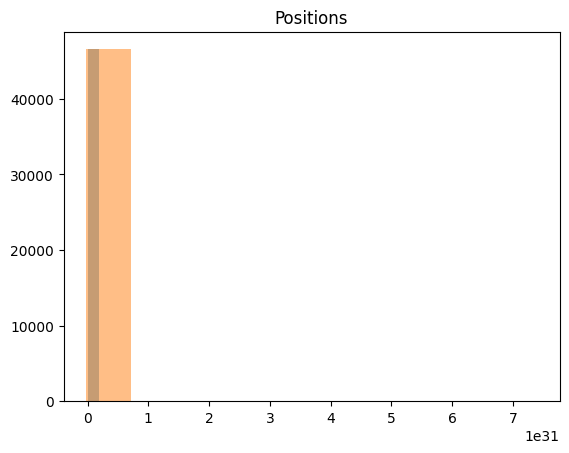

In [42]:
plt.title('Positions')
plt.hist(expert_actions[:, :, :, 0].flatten().numpy(), label='x', alpha=0.5, bins=10);
plt.hist(expert_actions[:, :, :, 1].flatten().numpy(), label='y', alpha=0.5, bins=10);

### Step through an episode

In [43]:
# Reset environment
obs = env.reset()

frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

# Step through the scene
for t in range(env_config.episode_len):

    env.step_dynamics(expert_actions[:, :, t, :])
    
    # Render the scenes
    for i in range(NUM_ENVS):
        frames[f"env_{i}"].append(env.render(i))

### Show resulting trajectories!

In [44]:
# Show videos
mediapy.show_videos(frames, fps=30, width=600, height=400, columns=2)